In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import sklearn
import random
from unicodedata import normalize
from keras.layers import Dense
from keras import Input
from keras import Model
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D

In [2]:
cd drive/MyDrive/sentiment\ analysis/Sentiment-Analysis/

/content/drive/MyDrive/sentiment analysis/Sentiment-Analysis


In [3]:
DATA_DIR_TEST = './Dataset/5차년도_2차_테스트'

In [4]:
DATA_DIR = './Dataset/5차년도_2차'

In [5]:
# Example : train폴더의 음성파일 접근
wav, sr = librosa.load(DATA_DIR + '/15f8a4ed69e04b149046cd1de_out.wav', sr=16000)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 16000
wav shape: (48470,)
length: 3.029375 secs


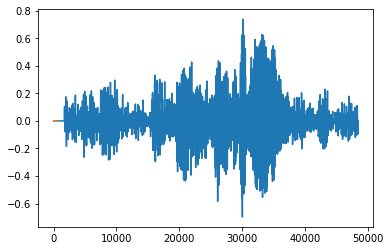

In [6]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [7]:
# Data set list, include (raw data, mfcc data, y data)
trainset = []
testset = []

# split each set into raw data, mfcc data, and y data
# STFT 한 것, CNN 분석하기 위해 Spectogram으로 만든 것, MF한 것, mel0spectogram 한 것
train_X = []
train_mfccs = []
train_y = []

test_X = []
test_mfccs = []
test_y = []

# 모든 음성파일의 길이가 같도록 후위에 padding 처리
pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

frame_length = 0.025
frame_stride = 0.0010

In [8]:
# train data를 넣는다.
for filename in os.listdir(DATA_DIR):
  filename = normalize('NFC', filename)
  try:
    # wav 포맷 데이터만 사용
    if '.wav' not in filename in filename:
      continue
      
    wav, sr = librosa.load(DATA_DIR+"/"+ filename, sr=16000)
    
    mfcc = librosa.feature.mfcc(wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    padded_mfcc = pad2d(mfcc, 300)

    # 추임새 별로 dataset에 추가
    if (os.path.basename(filename)).split('_')[1] == 'in.wav':
      trainset.append((padded_mfcc, 0))
    elif (os.path.basename(filename)).split('_')[1] == 'out.wav':
      trainset.append((padded_mfcc, 1))
    
  except Exception as e:
    print(filename, e)
    raise

# 학습 데이터를 무작위로 섞는다.
random.shuffle(trainset)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encou

In [9]:
# test data를 넣는다.
for filename in os.listdir(DATA_DIR_TEST):
  filename = normalize('NFC', filename)
  try:
    # wav 포맷 데이터만 사용
    if '.wav' not in filename in filename:
      continue
      
    wav, sr = librosa.load(DATA_DIR+"/"+ filename, sr=16000)
    
    mfcc = librosa.feature.mfcc(wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    padded_mfcc = pad2d(mfcc, 300)

    # 추임새 별로 dataset에 추가
    if (os.path.basename(filename)).split('_')[1] == 'in.wav':
      testset.append((padded_mfcc, 0))
    elif (os.path.basename(filename)).split('_')[1] == 'out.wav':
      testset.append((padded_mfcc, 1))

  except Exception as e:
    print(filename, e)
    raise

# 평가 데이터를 무작위로 섞는다.
random.shuffle(testset)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and mig

In [10]:
train_mfccs = [a for (a,b) in trainset]
train_y = [b for (a,b) in trainset]

test_mfccs = [a for (a,b) in testset]
test_y = [b for (a,b) in testset]

train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))

print('train_mfccs:', train_mfccs.shape)
print('train_y:', train_y.shape)

print('test_mfccs:', test_mfccs.shape)
print('test_y:', test_y.shape)

train_mfccs: (4034, 100, 300)
train_y: (4034, 2)
test_mfccs: (100, 100, 300)
test_y: (100, 2)


In [11]:
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

train X shape: (4034, 100, 300, 1)
test X shape: (100, 100, 300, 1)


In [12]:
ip = Input(shape=train_X_ex[0].shape)

m = Conv2D(32, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*2, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Flatten()(m)

m = Dense(64, activation='relu')(m)

m = Dense(32, activation='relu')(m)

op = Dense(2, activation='softmax')(m)

model = Model(ip, op)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 300, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 297, 64)       1088      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 74, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 113664)            0         
                                                                 
 dense (Dense)               (None, 64)                7274560   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                             

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_X_ex, test_y))

Epoch 1/20
127/127 [==============================] - 87s 679ms/step - loss: 1.7597 - accuracy: 0.5330 - val_loss: 0.6703 - val_accuracy: 0.5700
Epoch 2/20
127/127 [==============================] - 84s 663ms/step - loss: 0.6706 - accuracy: 0.5813 - val_loss: 0.6286 - val_accuracy: 0.5900
Epoch 3/20
127/127 [==============================] - 84s 660ms/step - loss: 0.6442 - accuracy: 0.6311 - val_loss: 0.5871 - val_accuracy: 0.8100
Epoch 4/20
127/127 [==============================] - 84s 663ms/step - loss: 0.6259 - accuracy: 0.6492 - val_loss: 0.5977 - val_accuracy: 0.7900
Epoch 5/20
127/127 [==============================] - 83s 654ms/step - loss: 0.5947 - accuracy: 0.6857 - val_loss: 0.5292 - val_accuracy: 0.8200
Epoch 6/20
127/127 [==============================] - 83s 651ms/step - loss: 0.5428 - accuracy: 0.7405 - val_loss: 0.6271 - val_accuracy: 0.5800
Epoch 7/20
127/127 [==============================] - 83s 652ms/step - loss: 0.4988 - accuracy: 0.7784 - val_loss: 0.3515 - val_ac

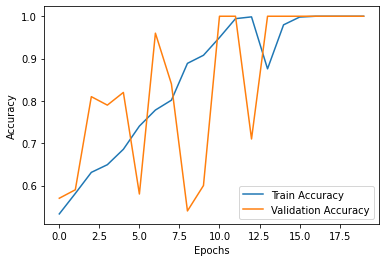

In [14]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [49]:
audio, sr = librosa.load(DATA_DIR+"/"+'15f8a4ed69e04b149046cd1de_out.wav')
mfcc = librosa.feature.mfcc(audio, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
padded_mfcc = pad2d(mfcc, 300)
padded_mfcc= np.expand_dims(padded_mfcc, 0)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


In [41]:
print(audio)

[ 0.          0.          0.         ... -0.08733884 -0.08868241
  0.        ]


In [45]:
model.predict(padded_mfcc)

array([[0.8669188 , 0.13308115]], dtype=float32)

In [46]:
import joblib

In [47]:
joblib.dump(model, 'model.pkl')

INFO:tensorflow:Assets written to: ram://f6da4da6-2735-482c-8ccf-469205eb81f7/assets


['model.pkl']

In [50]:
# 파일로 저장된 모델 불러와서 예측
clf_from_joblib = joblib.load('model.pkl') 
result = clf_from_joblib.predict(padded_mfcc)
print(result)

[[0.01866331 0.98133665]]
